# Principal component analysis
This notebook shows examples for the functions of the ramanbox package related to 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder

from boxsers.misc_tools import data_split
from boxsers.visual_tools import distribution_plot
from boxsers.preprocessing import savgol_smoothing, als_baseline_cor, intensity_normalization
from boxsers.machine_learning import SpectroPCA

## Database importation and label encoding

---

**Important Function/Class used :** 
- ``LabelEncoder`` (class from Scikit Learn): Converts label into integer values ordered in ascending order from zero.

**Comments :**
 - The labels occupy the first column (column 0) of the dataframe, which can be addressed by its tag 'Classes'.
 - The spectra occupy the remaining columns of the dataframe, the associated coordinates are therefore [0: , 1:].
 

In [2]:
df = pd.read_hdf('Bile_acids_27_07_2020.h5', key='df')  # Load bile acids dataframe
wn = np.load('Raman_shift_27_07_2020.npy')  # Load Wavenumber (Raman shift)
classnames = df['Classes'].unique()  

display(df)  # Prints a detailed overview of the imported dataframe "df"

# Features extraction: Exports dataframe spectra as a numpy array (value type = float64).
sp = df.iloc[:, 1:].to_numpy()
# Labels extraction: Export dataframe classes into a numpy array of string values.
label = df.loc[:, 'Classes'].values


# String to integer labels conversion: 
labelencoder = LabelEncoder()  # Creating instance of LabelEncoder
lab_int = labelencoder.fit_transform(label)  # 0, 3, 2, ...

,Classes,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,Blank,14698.0,14600.0,14933.0,15008.0,14864.0,14869.0,14982.0,14968.0,15026.0,...,5813.0,5717.0,5795.0,5865.0,5648.0,5667.0,5656.0,5764.0,5741.0,5807.0
1,Blank,14622.0,14329.0,14766.0,15041.0,14927.0,14907.0,14783.0,15076.0,15234.0,...,5778.0,5897.0,5735.0,5778.0,5695.0,5734.0,5627.0,5845.0,5666.0,5805.0
2,Blank,15225.0,15343.0,15557.0,15533.0,15518.0,15601.0,15366.0,15541.0,15645.0,...,5617.0,5574.0,5801.0,5672.0,5629.0,5648.0,5608.0,5690.0,5744.0,5726.0
3,Blank,15052.0,14922.0,15215.0,15310.0,15437.0,15208.0,15166.0,15625.0,15499.0,...,5740.0,5808.0,5958.0,5881.0,5828.0,5757.0,5877.0,5826.0,5822.0,5785.0
4,Blank,14211.0,14370.0,14346.0,14550.0,14601.0,14521.0,14431.0,14757.0,14741.0,...,5558.0,5607.0,5706.0,5747.0,5604.0,5546.0,5563.0,5682.0,5558.0,5543.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,TCDCA,13532.0,13549.0,13639.0,13916.0,13721.0,13758.0,13736.0,13828.0,13827.0,...,5694.0,5746.0,5649.0,5562.0,5608.0,5601.0,5603.0,5616.0,5528.0,5611.0
4796,TCDCA,13277.0,13086.0,13472.0,13415.0,13415.0,13459.0,13657.0,13387.0,13615.0,...,5743.0,5801.0,5769.0,5669.0,5639.0,5709.0,5718.0,5743.0,5768.0,5616.0
4797,TCDCA,14002.0,13930.0,13961.0,14149.0,14165.0,14155.0,14292.0,14107.0,14119.0,...,5679.0,5670.0,5718.0,5721.0,5578.0,5639.0,5596.0,5614.0,5637.0,5614.0
4798,TCDCA,14140.0,14022.0,14204.0,14271.0,14285.0,14313.0,14375.0,14258.0,14522.0,...,5936.0,6091.0,5975.0,6084.0,5859.0,5919.0,5950.0,5957.0,5997.0,5910.0


## Train, test split
----------------------------------

**Important Function/Class used :** 
   - ``data_split`` : Randomly splits an initial set of spectra into two new subsets named in this function: subset A and subset B.
   - ``distribution_plot`` : Return a bar plot that represents the distributions of spectra for each classes in a given set of spectra.
   

**Comments :**
- In this example, the initial set of spectra is divided according to the following proportions: 90% of the spectra for the training set and 10% for the test set.
- Write ``help(name of the function or the class)`` to get more information, namely on the parameters. 

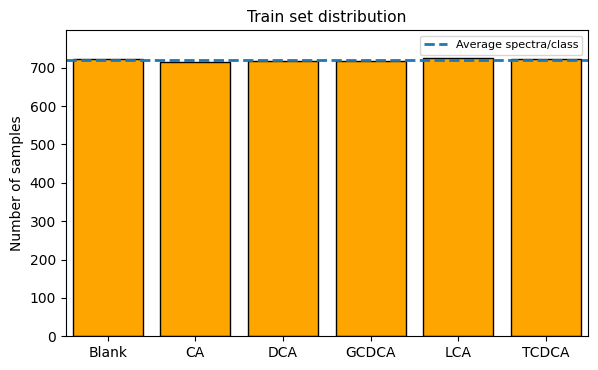

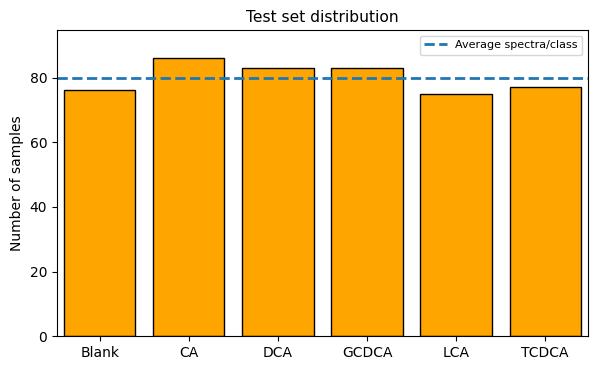

In [3]:
(sp_train, sp_test, lab_train, lab_test) = data_split(sp, label, b_size=0.10, rdm_ste=None, print_report=False)

distribution_plot(lab_train, class_names=classnames, avg_line=True, title='Train set distribution')
distribution_plot(lab_test, class_names=classnames, avg_line=True, title='Test set distribution')

In [4]:
def prep_method(x):
    x = als_baseline_cor(x, lam=1e4, p=0.001)
    x = savgol_smoothing(x, window_length=9, p=3, degree=0)
    x = intensity_normalization(x, norm='l2')
    return x

sp_train_p = prep_method(sp_train)
sp_test_p = prep_method(sp_test)

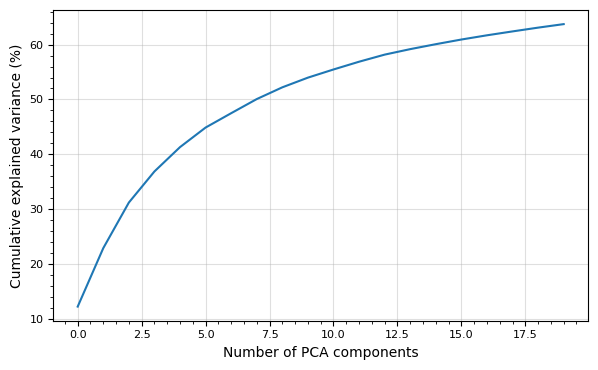

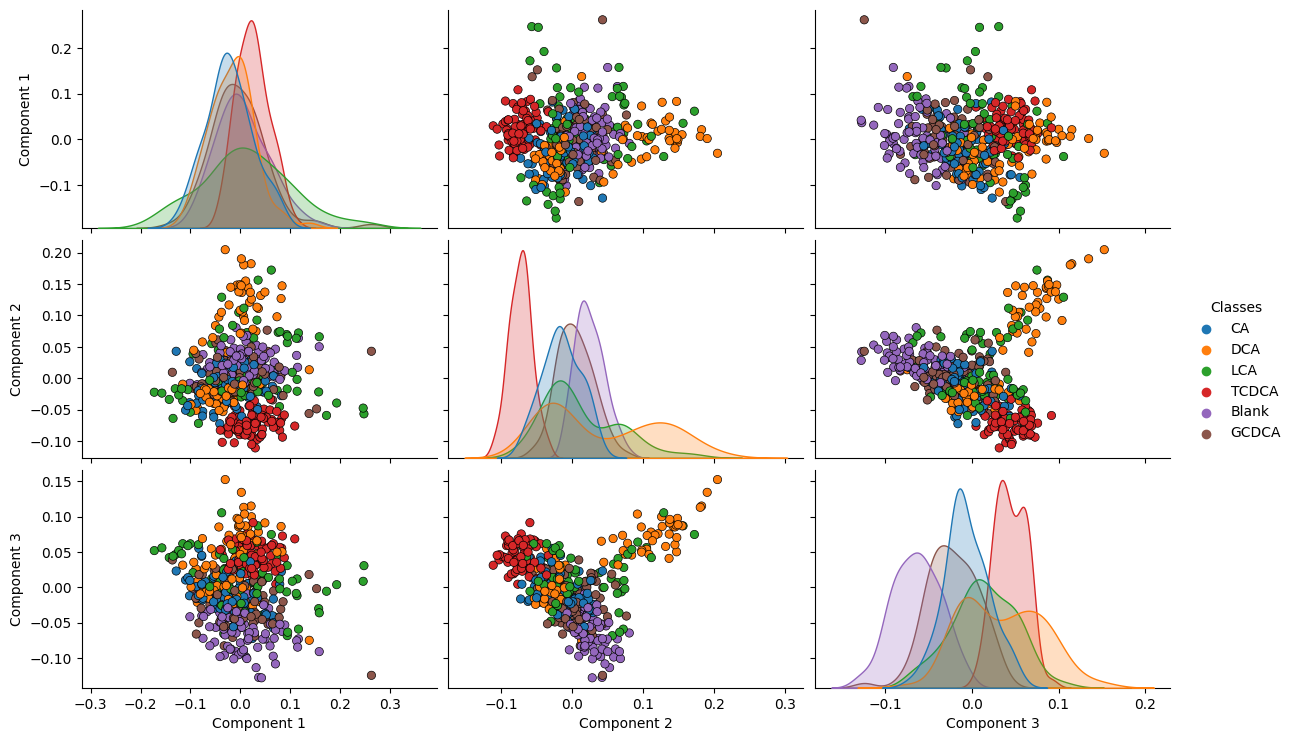

In [5]:
pca_model_val= SpectroPCA(n_comp=20)
pca_model_val.fit_model(sp_train_p)

pca_model_val.explained_var_plot()
pca_model_val.pair_plot(sp_test_p, lab_test, n_components=3)

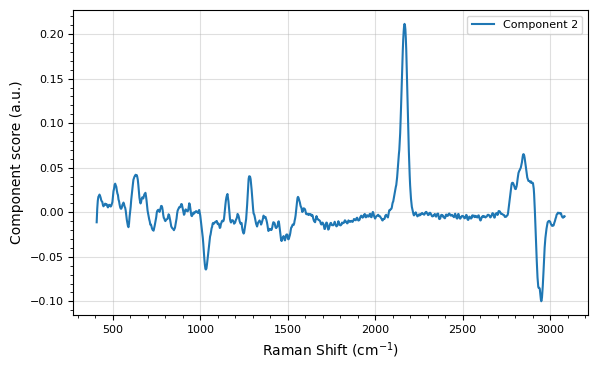

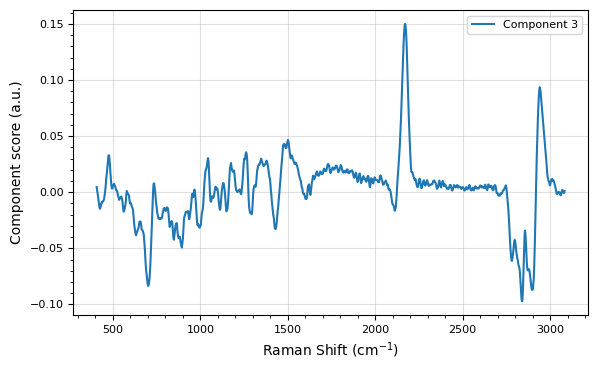

In [6]:
pca_model_val.component_plot(wn, 2)
pca_model_val.component_plot(wn, 3)

In [7]:
pca_model = SpectroPCA(n_comp=8)
pca_model.fit_model(sp_train_p)

sp_test_pca = pca_model.transform_spectra(sp_test_p)

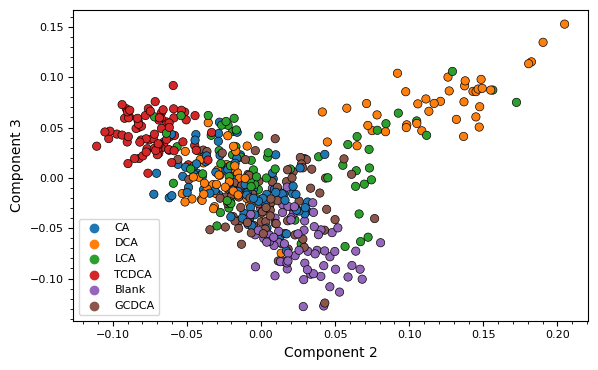

In [8]:
pca_model.scatter_plot(sp_test_p, lab_test, component_x=2, component_y=3,class_names=classnames)